<a href="https://colab.research.google.com/github/LuchoValr/The-effect/blob/main/cap18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Diferencias en diferencias con two-way foxed effects

In [2]:
!pip install causaldata
!pip install linearmodels
import linearmodels as lm
from causaldata import organ_donations


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.6 MB/s eta 0:00:00


In [3]:
od = organ_donations.load_pandas (). data

In [4]:
# Create Treatment Variable
od['California'] = od['State'] == 'California'
od['After'] = od['Quarter_Num'] > 3
od['Treated'] = 1*(od['California'] & od['After'])

In [5]:
# Set our individual and time (index) for our data
od = od.set_index (['State','Quarter_Num'])

In [6]:
mod = lm.PanelOLS.from_formula('''Rate ~ Treated + EntityEffects + TimeEffects''', od)

In [7]:
# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
               cluster_entity = True)
print(clfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   Rate   R-squared:                        0.0092
Estimator:                   PanelOLS   R-squared (Between):             -0.0010
No. Observations:                 162   R-squared (Within):              -0.0021
Date:                Mon, Jun 12 2023   R-squared (Overall):             -0.0010
Time:                        19:56:07   Log-likelihood                    388.57
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2006
Entities:                          27   P-value                           0.2752
Avg Obs:                       6.0000   Distribution:                   F(1,129)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.525
                            

#Placebo test para "testear" el supuesto de parallel trends

In [8]:
od = organ_donations.load_pandas (). data

In [9]:
# Keep only pre-treatment data
od = od.loc[od['Quarter_Num'] <= 3]

In [10]:
# Create fake treatment variables
od['California'] = od['State'] == 'California'
od['FakeAfter1'] = od['Quarter_Num'] > 1
od['FakeAfter2'] = od['Quarter_Num'] > 2
od['FakeTreat1'] = 1*(od['California'] & od['FakeAfter1'])
od['FakeTreat2'] = 1*(od['California'] & od['FakeAfter2'])

<ipython-input-10-47da61c46657>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od['California'] = od['State'] == 'California'
<ipython-input-10-47da61c46657>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od['FakeAfter1'] = od['Quarter_Num'] > 1
<ipython-input-10-47da61c46657>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [11]:
# Set our individual and time (index) for our data
od = od.set_index (['State','Quarter_Num'])


In [12]:
# Run the same model as before
# but with our fake treatment variables
mod1 = lm.PanelOLS.from_formula('''Rate ~ FakeTreat1 + EntityEffects + TimeEffects''',od)
mod2 = lm.PanelOLS.from_formula('''Rate ~ FakeTreat2 + EntityEffects + TimeEffects''',od)

In [14]:
clfe1 = mod1.fit(cov_type = 'clustered', cluster_entity = True)
clfe2 = mod1.fit(cov_type = 'clustered', cluster_entity = True)

In [17]:
print(clfe1, clfe2)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   Rate   R-squared:                        0.0019
Estimator:                   PanelOLS   R-squared (Between):              0.0004
No. Observations:                  81   R-squared (Within):               0.0025
Date:                Mon, Jun 12 2023   R-squared (Overall):              0.0004
Time:                        20:07:17   Log-likelihood                    240.84
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0979
Entities:                          27   P-value                           0.7556
Avg Obs:                       3.0000   Distribution:                    F(1,51)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             0.9733
                            

#Dynamic treatment effect

In [26]:
import pandas as pd
import matplotlib as plt

In [37]:
od = organ_donations.load_pandas (). data

In [38]:
# Create Treatment Variable
od['California'] = od['State'] == 'California'

In [39]:
# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in [1, 2, 4, 5, 6]:
  name = 'INX'+str(i)
  od[name] = 1*od['California']
  od.loc[od['Quarter_Num'] != i, name] = 0


In [40]:
# Set our individual and time (index) for our data
od = od.set_index (['State','Quarter_Num'])

In [41]:
mod = lm.PanelOLS.from_formula('''Rate ~ INX1 + INX2 + INX4 + INX5 + INX6 + EntityEffects + TimeEffects''',od)

In [42]:
# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered', cluster_entity = True)

In [43]:
# Get coefficients and CIs
res = pd.concat([clfe.params , clfe.std_errors], axis = 1)

In [44]:
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

In [45]:
# Add our quarter values
res['Quarter_Num'] = [1, 2, 4, 5, 6]

In [46]:
# And add our reference period back in
reference = pd.DataFrame ([[0,0,0,3]], 
                          columns = ['parameter ', 
                                     'lower', 
                                     'upper', 
                                     'Quarter_Num '])
res = pd.concat([res , reference ])

In [47]:
# For plotting , sort and add labels
res = res.sort_values('Quarter_Num')

In [48]:
res['Quarter'] = ['Q42010','Q12011', 
                   'Q22011','Q32011', 
                   'Q42011','Q12012']

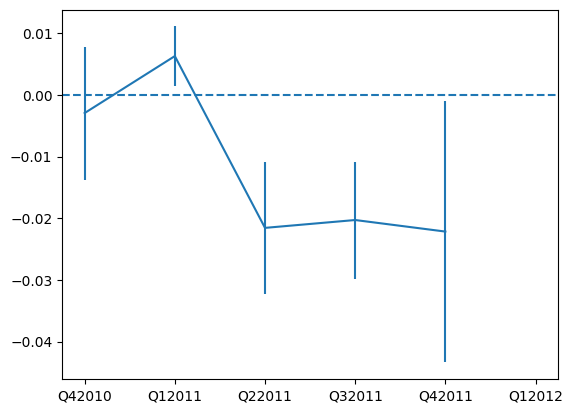

In [51]:
# Plot the estimates as connected lines with error bars
plt.pyplot.errorbar(x = 'Quarter', y = 'parameter', yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.pyplot.axhline(0, linestyle = 'dashed')